In [1]:
%load_ext autoreload
%autoreload 2

# Gromov-Wasserstein

In this tutorial, we present the {class}`~ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein` {cite}`memoli:11` solver. The goal of the GW problem is to match two point clouds, taken from different spaces endowed with their own geometries. We illustrate this use case by aligning a 2-d to a 3-d {class}`point clouds <ott.geometry.pointcloud.PointCloud>`, see also {doc}`gromov_wasserstein_multiomics` for a more challenging application to single-cell omics.

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [3]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from IPython import display
from matplotlib import animation, cm

from ott import datasets
from ott.geometry import pointcloud
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import gromov_wasserstein

## Matching across spaces

We use the {class}`~ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein` solver to match a $2$-$d$ spiral to a $3$-$d$ a spiral. We generate each spiral with linearly increasing angles, s.t. the resulting mathcing between these two point clouds is close to the identity.

In [4]:
rng = jax.random.PRNGKey(0)
n_source, n_target = 400, 500
source_iter = iter(
    datasets.SortedSprial(rng, batch_size=n_source, dim_data=3, std_noise=0.01)
)
target_iter = iter(
    datasets.SortedSprial(rng, batch_size=n_target, dim_data=2, std_noise=0.8)
)
source_samples = next(source_iter)
target_samples = next(target_iter)

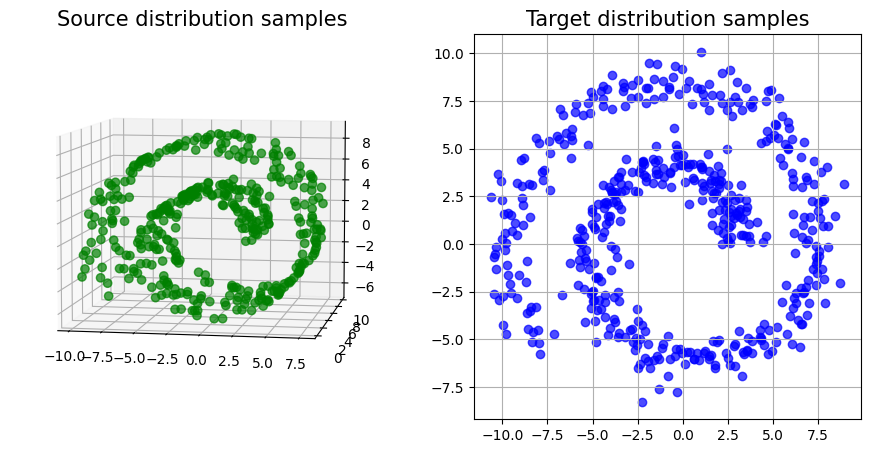

In [5]:
def plot(
    source_samples,
    target_samples,
    source_colormap,
    target_colormap,
    source_sizes=36,
    target_sizes=36,
):
    fig = plt.figure(figsize=(11, 5))

    # plot source samples
    ax = fig.add_subplot(1, 2, 1, projection="3d")
    ax.view_init(7, -80)
    assert (
        source_samples.shape[-1] == 3
    ), "Source distribution dimensionality must be 3."
    ax.scatter(
        source_samples[:, 0],
        source_samples[:, 1],
        source_samples[:, 2],
        c=source_colormap,
        s=source_sizes,
        alpha=0.7,
    )
    ax.set_title("Source distribution samples", fontsize=15)
    ax.set_adjustable("box")

    # plot target samples
    ax = fig.add_subplot(1, 2, 2)
    assert (
        target_samples.shape[-1] == 2
    ), "Target distribution dimensionality must be 2."
    ax.scatter(
        target_samples[:, 0],
        target_samples[:, 1],
        c=target_colormap,
        s=target_sizes,
        alpha=0.7,
    )
    ax.set_title("Target distribution samples", fontsize=15)
    ax.grid()

    plt.show()


plot(
    source_samples,
    target_samples,
    source_colormap="green",
    target_colormap="blue",
)

We define two {class}`point clouds <ott.geometry.pointcloud.PointCloud>` to describe each of these point clouds, each using (by default) the {class}`~ott.geometry.costs.SqEuclidean` cost function.

In [6]:
# Instantiate the Quadratic Alignment Problem
geom_xx = pointcloud.PointCloud(x=source_samples, y=source_samples)
geom_yy = pointcloud.PointCloud(x=target_samples, y=target_samples)
prob = quadratic_problem.QuadraticProblem(geom_xx, geom_yy)

# Instantiate a jitt'ed Gromov-Wasserstein solver
solver = jax.jit(
    gromov_wasserstein.GromovWasserstein(
        epsilon=100.0, max_iterations=20, store_inner_errors=True
    )
)
out = solver(prob)

has_converged = bool(out.linear_convergence[out.n_iters - 1])
print(f"{out.n_iters} outer iterations were needed.")
print(f"The last Sinkhorn iteration has converged: {has_converged}")
print(f"The outer loop of Gromov Wasserstein has converged: {out.converged}")
print(f"The final regularized GW cost is: {out.reg_gw_cost:.3f}")

5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 1136.240


The resulting transport matrix $\pi_\varepsilon^\star$ between the two point clouds is as follows:

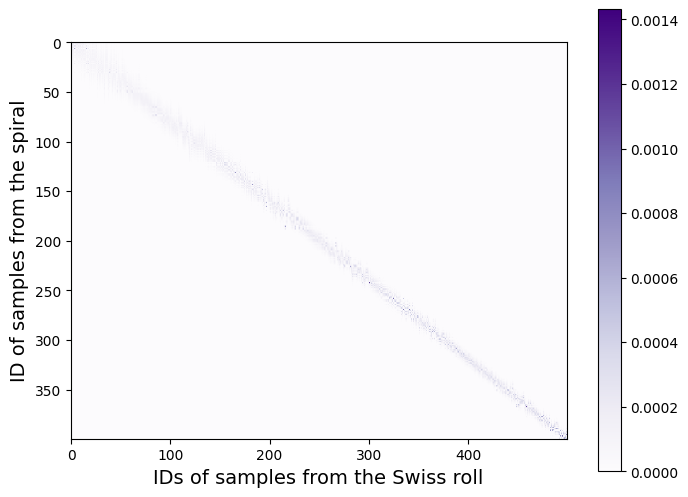

In [7]:
transport = out.matrix
fig = plt.figure(figsize=(8, 6))
plt.imshow(transport, cmap="Purples")
plt.xlabel(
    "IDs of samples from the Swiss roll", fontsize=14
)  # IDs are ordered from center to outer part
plt.ylabel(
    "ID of samples from the spiral", fontsize=14
)  # IDs are ordered from center to outer part
plt.colorbar()
plt.show()

The larger the regularization parameter `epsilon` is, the more diffuse the transport matrix becomes, as we can see in the animation below.

In [9]:
# Animates the transport matrix
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(transport, cmap="Purples")
plt.xlabel(
    "IDs of samples from the Swiss roll", fontsize=14
)  # IDs are ordered from center to outer part
plt.ylabel(
    "IDs of samples from the spiral", fontsize=14
)  # IDs are ordered from center to outer part
plt.colorbar()

# Initialization function


def init():
    im.set_data(np.zeros(transport.shape))
    return [im]


# Animation function
def animate(i):
    _ = im.get_array()
    geom_xx = pointcloud.PointCloud(x=source_samples, y=source_samples)
    geom_yy = pointcloud.PointCloud(x=target_samples, y=target_samples)
    prob = quadratic_problem.QuadraticProblem(geom_xx, geom_yy)

    solver = gromov_wasserstein.GromovWasserstein(epsilon=i, max_iterations=20)

    out = solver(prob)

    im.set_array(out.matrix)
    im.set_clim(0, jnp.max(out.matrix[:]))
    return [im]


# Call the animator
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=[70.0, 100.0, 200.0, 500.0, 750.0, 1000.0, 2000.0, 10000.0, 50000.0],
    interval=1500,
    blit=True,
)

html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()

To better understand the correspondence found by the {class}`~ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein` solver,
we plot in the same color, for some points $\mathbf{x}_i$ in the source $2$-$d$ spiral, some conditional samples $\mathbf{y}_j \sim \pi_\varepsilon^\star(\cdot | \mathbf{x}_i)$ in the target $3$-$d$ spiral.

In [10]:
# For a bunch of x samples from the source spiral,
# we samples n point in the target spiral from the conditonal disribution
# of the coupling matrix given x
n_select, n_samples_per_x = 4, 30
step = n_source // n_select
selected_source_samples = source_samples[jnp.arange(n_source, step=step)]
cond_probs = n_source * out.matrix
sample_cond_from_index = lambda i: jax.random.choice(
    key=jax.random.PRNGKey(i),
    a=jnp.arange(n_target),
    p=n_source * transport[i],
    shape=(n_samples_per_x,),
)
cond_indices = jax.vmap(sample_cond_from_index)(jnp.arange(n_source, step=step))

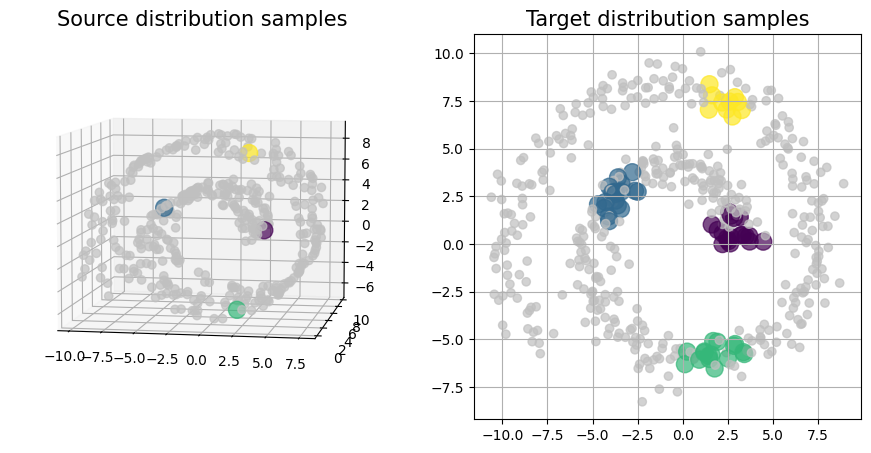

In [11]:
# Sets colors to visualise matching of some areas between each shape
# IDs of spiral and Swiss roll are ordered from center to outer part
discrete_colors = plt.get_cmap("viridis")(np.linspace(0, 1, n_select))
sliver_rgb = np.array([0.7529, 0.7529, 0.7529, 1.0])
default_size, big_size = 36, 150

source_colormap = [sliver_rgb] * n_source
source_sizes = [default_size] * n_source
for i in range(n_source):
    if i % step == 0:
        source_colormap[i] = discrete_colors[i // step]
        source_sizes[i] = big_size

target_colormap = [sliver_rgb] * n_target
target_sizes = [default_size] * n_target
for i in range(n_source):
    for j in range(n_select):
        if (
            i in cond_indices[j]
        ):  # assume each i is only in one cond_indices group
            target_colormap[i] = discrete_colors[j]
            target_sizes[i] = big_size

plot(
    source_samples,
    target_samples,
    source_colormap,
    target_colormap,
    source_sizes,
    target_sizes,
)